## 4. Deep Lerning

### 4.1 Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import cv2
from torch.utils.data import DataLoader, TensorDataset

# Check for GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


### 4.2 Load up Baarle Hertog data

In [2]:
m = cv2.imread("data/Baarle-Nassau_-_Baarle-Hertog-en no legend.png")[:, :, (2, 1, 0)]

belgium_color = np.array([251, 234, 81])
netherlands_color = np.array([255, 255, 228])

netherlands_region = ((m - netherlands_color) ** 2).sum(-1) < 50
belgium_region = ((m - belgium_color) ** 2).sum(-1) < 10000

b_coords = np.array(np.where(belgium_region)).T.astype("float")
n_coords = np.array(np.where(netherlands_region)).T.astype("float")

# Flip and normalize coordinates to [-1, 1]
belgium_coords_all = np.zeros_like(b_coords)
netherlands_coords_all = np.zeros_like(n_coords)

belgium_coords_all[:, 0] = b_coords[:, 1] / (960 / 2) - 1
belgium_coords_all[:, 1] = (960 - b_coords[:, 0]) / (960 / 2) - 1
netherlands_coords_all[:, 0] = n_coords[:, 1] / (960 / 2) - 1
netherlands_coords_all[:, 1] = (960 - n_coords[:, 0]) / (960 / 2) - 1

In [3]:
np.random.seed(55)
num_points_to_sample = 10000
belgium_coords_sample = belgium_coords_all[
    np.random.choice(len(belgium_coords_all), num_points_to_sample), :
]
netherlands_coords_sample = netherlands_coords_all[
    np.random.choice(len(netherlands_coords_all), num_points_to_sample), :
]
X_sample = np.vstack((netherlands_coords_sample, belgium_coords_sample))
y_sample = np.concatenate(
    (np.zeros(len(belgium_coords_sample)), np.ones(len(netherlands_coords_sample)))
).astype("int")

rI = np.arange(len(y_sample))
np.random.shuffle(rI)
X_sample = X_sample[rI, :]
y_sample = y_sample[rI]

X_sample = torch.FloatTensor(X_sample)
y_sample = torch.tensor(y_sample)

In [4]:
# Full dataset (no sampling)
belgium_coords = belgium_coords_all
netherlands_coords = netherlands_coords_all

X = np.vstack((netherlands_coords, belgium_coords))
y = np.concatenate(
    (np.zeros(len(netherlands_coords)), np.ones(len(belgium_coords)))
).astype("int")

rI = np.arange(len(y))
np.random.shuffle(rI)
X = X[rI, :]
y = y[rI]

X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

In [5]:
X_tensor.shape, y_tensor.shape, X_sample.shape, y_sample.shape

(torch.Size([855665, 2]),
 torch.Size([855665]),
 torch.Size([20000, 2]),
 torch.Size([20000]))

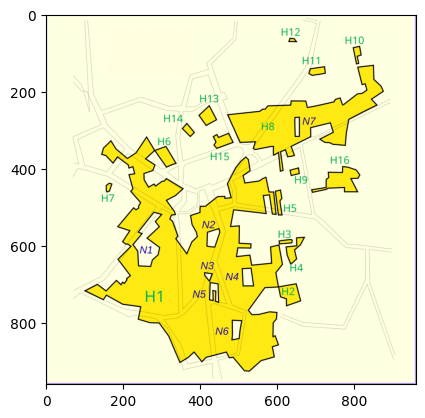

In [6]:
plt.imshow(m)

(-1.0930208086967468,
 1.0909375071525573,
 -1.0909375071525573,
 1.0930208086967468)

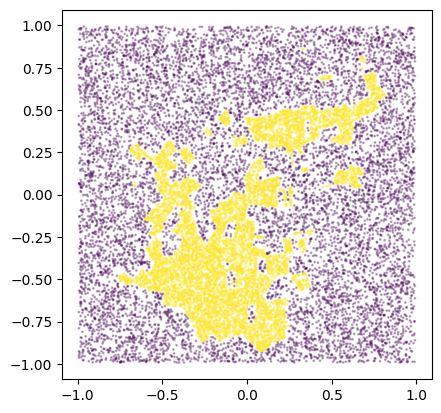

In [7]:
plt.scatter(X_sample[:, 0], X_sample[:, 1], c=y_sample, s=1, alpha=0.3)
plt.axis("square")

### 4.3 Network 

In [8]:
class BaarleNet(nn.Module):
    def __init__(self, hidden_layers):
        super().__init__()

        layers = []
        in_dim = 2
        for h in hidden_layers:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.GELU())
            in_dim = h
        layers.append(nn.Linear(in_dim, 2))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [9]:
def viz_descision_boundary(model, res=256):
    plt.clf()
    fig = plt.figure(0, (6, 6))
    ax = fig.add_subplot(111)

    probe = np.zeros((res, res, 2))
    for j, xx in enumerate(np.linspace(-1, 1, res)):
        for k, yy in enumerate(np.linspace(-1, 1, res)):
            probe[j, k] = [yy, xx]
    probe = probe.reshape(res**2, -1)
    probe_logits = model(torch.tensor(probe).float().to(device))
    probe_logits = probe_logits.detach().cpu().numpy().reshape(res, res, 2)

    ax.imshow(m.mean(2), cmap="gray")
    ax.imshow(
        np.flipud(np.argmax(probe_logits, 2)),
        extent=[0, 960, 960, 0],
        alpha=0.7,
        cmap="viridis",
    )

### 4.4 Two Layers, Three Hidden Neurons (Figure 4.1)

In [10]:
random_seed = 520  # Random seed of 3 makes for a nice "fold down the edges" deal,
num_neurons = 3

torch.manual_seed(random_seed)

model = BaarleNet([num_neurons])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 10000
for epoch in range(num_epochs):

    # Stochastic - works better for these smaller networks.
    outputs = model(torch.tensor(X_sample[epoch % len(y_sample)]).float())
    loss = criterion(outputs, torch.tensor(y_sample[epoch % len(y_sample)]))

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()
    if (epoch + 1) % (num_epochs // 25) == 0:
        outputs_batch = model(X_sample)
        accuracy = (torch.argmax(outputs_batch, dim=1) == y_sample).sum().item() / len(
            y_sample
        )
        print(
            f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}"
        )

/tmp/ipykernel_802310/1050930966.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(X_sample[epoch % len(y_sample)]).float())
/tmp/ipykernel_802310/1050930966.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs, torch.tensor(y_sample[epoch % len(y_sample)]))


Epoch [400/10000], Loss: 0.3760, Accuracy: 0.6383
Epoch [800/10000], Loss: 0.5296, Accuracy: 0.7225
Epoch [1200/10000], Loss: 0.4908, Accuracy: 0.7861
Epoch [1600/10000], Loss: 0.3400, Accuracy: 0.8151
Epoch [2000/10000], Loss: 0.9875, Accuracy: 0.8172
Epoch [2400/10000], Loss: 0.3308, Accuracy: 0.8172
Epoch [2800/10000], Loss: 0.5861, Accuracy: 0.8269
Epoch [3200/10000], Loss: 0.0191, Accuracy: 0.8165
Epoch [3600/10000], Loss: 0.4600, Accuracy: 0.8194
Epoch [4000/10000], Loss: 0.1988, Accuracy: 0.8346
Epoch [4400/10000], Loss: 0.2545, Accuracy: 0.8338
Epoch [4800/10000], Loss: 1.6198, Accuracy: 0.8088
Epoch [5200/10000], Loss: 0.0860, Accuracy: 0.8394
Epoch [5600/10000], Loss: 0.1262, Accuracy: 0.8473
Epoch [6000/10000], Loss: 0.0106, Accuracy: 0.8301
Epoch [6400/10000], Loss: 0.2835, Accuracy: 0.8424
Epoch [6800/10000], Loss: 0.1010, Accuracy: 0.8268
Epoch [7200/10000], Loss: 0.0737, Accuracy: 0.8390
Epoch [7600/10000], Loss: 0.0134, Accuracy: 0.8479
Epoch [8000/10000], Loss: 0.2010,

<Figure size 640x480 with 0 Axes>

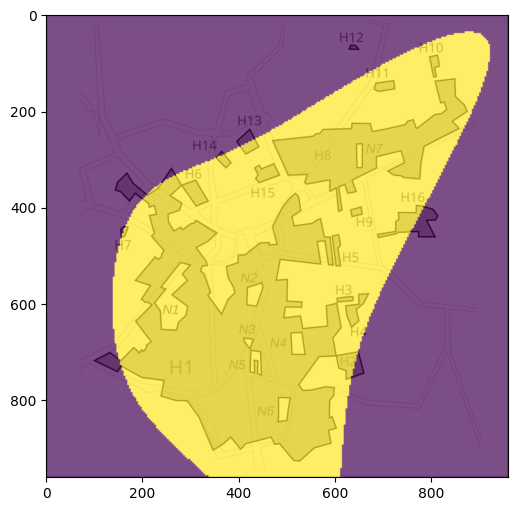

In [11]:
viz_descision_boundary(model.to(device))

### 4.4 Two Layers, Eight Hidden Neurons (Figure 4.4)

In [12]:
%%time
batch_size = 10000
random_seed = 571

torch.manual_seed(random_seed)
X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Create dataset and dataloader for minibatching
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = BaarleNet([22, 19, 16, 13, 11, 10, 8]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.02)
num_epochs = 1000

# Cosine annealing learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=num_epochs, eta_min=0.02 * 0.01
)

model.compile()

CPU times: user 1.42 s, sys: 85.9 ms, total: 1.51 s
Wall time: 1.47 s


In [13]:
%%time
for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0

    for batch_X, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_X.to(device))
        loss = criterion(outputs, batch_y.to(device))

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        num_batches += 1

    # Step the cosine annealing scheduler
    scheduler.step()

    # Calculate average loss for the epoch
    avg_loss = epoch_loss / num_batches

    # Calculate accuracy on sample dataset
    with torch.no_grad():
        outputs_batch = model(X_sample.to(device))
        accuracy = (
            torch.argmax(outputs_batch, dim=1) == y_sample.to(device)
        ).sum().item() / len(y_sample)

    current_lr = scheduler.get_last_lr()[0]
    print(
        f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, LR: {current_lr:.6f}"
    )

Epoch [1/1000], Loss: 0.3973, Accuracy: 0.7635, LR: 0.020000
Epoch [2/1000], Loss: 0.2007, Accuracy: 0.8679, LR: 0.020000
Epoch [3/1000], Loss: 0.1507, Accuracy: 0.9054, LR: 0.020000
Epoch [4/1000], Loss: 0.1246, Accuracy: 0.9224, LR: 0.019999
Epoch [5/1000], Loss: 0.1007, Accuracy: 0.9484, LR: 0.019999
Epoch [6/1000], Loss: 0.0829, Accuracy: 0.9456, LR: 0.019998
Epoch [7/1000], Loss: 0.0744, Accuracy: 0.9456, LR: 0.019998
Epoch [8/1000], Loss: 0.0712, Accuracy: 0.9630, LR: 0.019997
Epoch [9/1000], Loss: 0.0615, Accuracy: 0.9653, LR: 0.019996
Epoch [10/1000], Loss: 0.0561, Accuracy: 0.9698, LR: 0.019995
Epoch [11/1000], Loss: 0.0569, Accuracy: 0.9601, LR: 0.019994
Epoch [12/1000], Loss: 0.0504, Accuracy: 0.9636, LR: 0.019993
Epoch [13/1000], Loss: 0.0545, Accuracy: 0.9623, LR: 0.019992
Epoch [14/1000], Loss: 0.0471, Accuracy: 0.9704, LR: 0.019990
Epoch [15/1000], Loss: 0.0453, Accuracy: 0.9755, LR: 0.019989
Epoch [16/1000], Loss: 0.0421, Accuracy: 0.9721, LR: 0.019987
Epoch [17/1000], 

<Figure size 640x480 with 0 Axes>

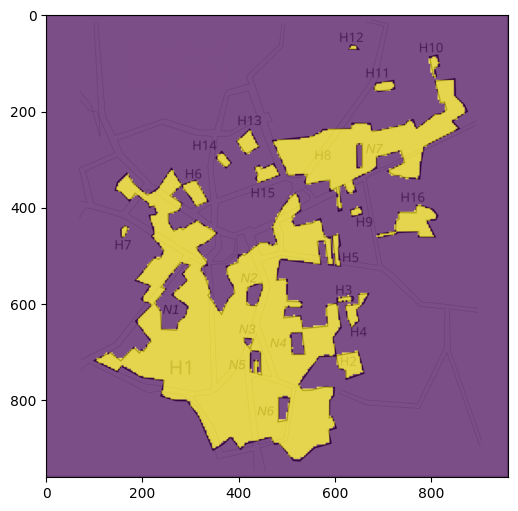

In [14]:
viz_descision_boundary(model)

### 4.5 Wider Models (Figure 4.5)
Ramp up width as desired here

In [15]:
batch_size = 10000
random_seed = 26

torch.manual_seed(random_seed)
X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Create dataset and dataloader for minibatching
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = BaarleNet([16]).to(device)  # Ramp up model width here as desired
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.05)
num_epochs = 5

Epoch [1/5], Loss: 0.3507, Accuracy: 0.7648
Epoch [2/5], Loss: 0.2466, Accuracy: 0.8115


Epoch [3/5], Loss: 0.2259, Accuracy: 0.7880
Epoch [4/5], Loss: 0.2200, Accuracy: 0.8145
Epoch [5/5], Loss: 0.2178, Accuracy: 0.8146


<Figure size 640x480 with 0 Axes>

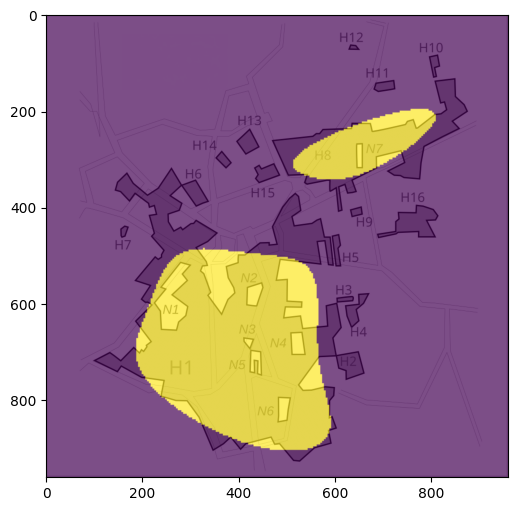

In [16]:
for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0

    for batch_X, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_X.to(device))
        loss = criterion(outputs, batch_y.to(device))

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        num_batches += 1

    # Calculate average loss for the epoch
    avg_loss = epoch_loss / num_batches

    # Calculate accuracy on sample dataset
    with torch.no_grad():
        outputs_batch = model(X_sample.to(device))
        accuracy = (
            torch.argmax(outputs_batch, dim=1) == y_sample.to(device)
        ).sum().item() / len(y_sample)
    print(
        f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}"
    )

viz_descision_boundary(model)

### 4.6 Network Walkthrough -  Figure 4.14
Repoduce network walkthrough in Figure 4.14 

In [17]:
def denorm(p, size=960):
    result = np.zeros_like(p)
    result[..., 0] = (p[..., 0] + 1) * (size / 2)
    result[..., 1] = size - ((p[..., 1] + 1) * (size / 2))
    return result

In [18]:
map = cv2.imread("data/Baarle-Nassau_-_Baarle-Hertog-en no legend.png")[:, :, (2, 1, 0)]

belgium_color = np.array([251, 234, 81])
netherlands_color = np.array([255, 255, 228])

netherlands_region = ((map - netherlands_color) ** 2).sum(-1) < 10
belgium_region = ((map - belgium_color) ** 2).sum(-1) < 10000

num_points_to_sample = 10000

b_coords = np.array(np.where(belgium_region)).T.astype("float")
n_coords = np.array(np.where(netherlands_region)).T.astype("float")

# Flip and normalize
belgium_coords_all = np.zeros_like(b_coords)
netherlands_coords_all = np.zeros_like(n_coords)

belgium_coords_all[:, 0] = b_coords[:, 1] / (960 / 2) - 1
belgium_coords_all[:, 1] = (960 - b_coords[:, 0]) / (960 / 2) - 1
netherlands_coords_all[:, 0] = n_coords[:, 1] / (960 / 2) - 1
netherlands_coords_all[:, 1] = (960 - n_coords[:, 0]) / (960 / 2) - 1

belgium_coords = belgium_coords_all[
    np.random.choice(len(belgium_coords_all), num_points_to_sample), :
]
netherlands_coords = netherlands_coords_all[
    np.random.choice(len(netherlands_coords_all), num_points_to_sample), :
]

X = np.vstack((netherlands_coords, belgium_coords))
y = np.concatenate(
    (np.zeros(len(netherlands_coords)), np.ones(len(belgium_coords)))
).astype("int")

rI = np.arange(len(y))
np.random.shuffle(rI)
X = X[rI, :]
y = y[rI]

In [19]:
class BaarleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(nn.Linear(2, 2), nn.ReLU(), nn.Linear(2, 2))

    def forward(self, x):
        return self.model(x)

In [20]:
model = BaarleNet()
model.load_state_dict(torch.load("data/2_1.pth"))
model.eval()

BaarleNet(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2, out_features=2, bias=True)
  )
)

In [21]:
print("First layer (input → hidden):")
print("W1 =", model.model[0].weight.data.numpy())
print("b1 =", model.model[0].bias.data.numpy())
print("\nSecond layer (hidden → output):")
print("W2 =", model.model[2].weight.data.numpy())
print("b2 =", model.model[2].bias.data.numpy())

First layer (input → hidden):
W1 = [[ 2.513498  -1.024808 ]
 [-1.404299   2.4129117]]
b1 = [-1.2398118  -0.45007765]

Second layer (hidden → output):
W2 = [[ 3.170242   1.3256735]
 [-3.4037237 -1.5387845]]
b2 = [-0.8848354   0.03322279]


In [22]:
x_test = np.array([0.6, 0.4])
x_belgium = torch.tensor(x_test, dtype=torch.float32)
print("Input:", x_test)

Input: [0.6 0.4]


In [23]:
with torch.no_grad():
    # First layer (before ReLU)
    h1_pre = model.model[0](x_belgium)
    print("After first linear layer (before ReLU):", h1_pre.numpy())

    # After ReLU
    h1_post = model.model[:2](x_belgium)
    print("After ReLU activation:", h1_post.numpy())

    # Output layer
    output = model(x_belgium)
    print("Final output (Netherlands, Belgium):", output.numpy())

After first linear layer (before ReLU): [-0.14163601 -0.32749242]
After ReLU activation: [0. 0.]
Final output (Netherlands, Belgium): [-0.8848354   0.03322279]


In [24]:
# Extract weights
W1 = model.model[0].weight.data.numpy()
b1 = model.model[0].bias.data.numpy()
W2 = model.model[2].weight.data.numpy()
b2 = model.model[2].bias.data.numpy()

x = x_test

# First layer computation
h1_pre = W1 @ x + b1
print("First layer (before ReLU):", h1_pre)

# ReLU activation
h1_post = np.maximum(0, h1_pre)
print("After ReLU:", h1_post)

# Second layer computation
output = W2 @ h1_post + b2
print("Final output:", output)
print("Predicted class:", "Belgium" if output[1] > output[0] else "Netherlands")

First layer (before ReLU): [-0.14163616 -0.3274924 ]
After ReLU: [0. 0.]
Final output: [-0.88483542  0.03322279]
Predicted class: Belgium


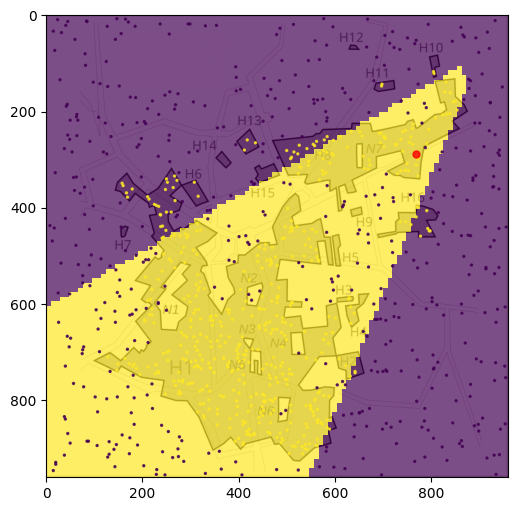

In [25]:
fig = plt.figure(0, (6, 6))
ax = fig.add_subplot(111)

ax.imshow(map.mean(2), cmap="gray")

X_denorm = denorm(X[:1000, :])
plt.scatter(X_denorm[:, 0], X_denorm[:, 1], c=y[:1000], s=2, alpha=0.8)

X_denorm = denorm(x_test)
plt.scatter(X_denorm[0], X_denorm[1], c="r", s=25, alpha=0.8)

probe = np.zeros((100, 100, 2))
for j, xx in enumerate(np.linspace(-1, 1, 100)):
    for k, yy in enumerate(np.linspace(-1, 1, 100)):
        probe[j, k] = [yy, xx]
probe = probe.reshape(100**2, -1)
probe_logits = model(torch.tensor(probe).float())
probe_logits = probe_logits.detach().numpy().reshape(100, 100, 2)
ax.imshow(
    np.flipud(np.argmax(probe_logits, 2)),
    extent=[0, 960, 960, 0],
    alpha=0.7,
    cmap="viridis",
)